In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools

In [2]:
#file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025_norge.csv"
df = pd.read_csv(file_path, sep=";")

In [3]:
df = df[df["EGS.VEDTAK.10670"].notna()]

In [4]:
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" else 0)

In [5]:
if "Kurvatur, horisontalelement" in df.columns:
    df["Kurvatur, horisontal"] = df["Kurvatur, horisontalelement"]

In [6]:
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    "Kurvatur, stigning"
]

# Encode categorical features
df_encoded = pd.get_dummies(df[features])

In [7]:
df_encoded=df_encoded.dropna()

In [8]:
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()
df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns

In [9]:
poly = PolynomialFeatures(3, include_bias=False, interaction_only=True) 
#X = pd.DataFrame(poly.fit_transform(X),columns=poly.get_feature_names_out(X.columns))

In [10]:
# Identify binary dummy columns: only {0,1} or {0.0,1.0}
binary_cols = [
    col for col in X.columns
    if np.isin(X[col].dropna().unique(), [0,1]).all()
]

continuous_cols = [col for col in X.columns if col not in binary_cols]

# Transform only continuous columns
scaler = PowerTransformer()
X_cont_scaled = pd.DataFrame(
    scaler.fit_transform(X[continuous_cols]),
    columns=continuous_cols,
    index=X.index
)

# Combine back into full feature matrix
X = pd.concat([X_cont_scaled, X[binary_cols]], axis=1)

In [11]:
from sklearn.decomposition import PCA

n_components = 100
pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X)

# Auto-generate names: PC1, PC2, ..., PCn
pc_names = [f"PC{i+1}" for i in range(n_components)]

X_pca_df = pd.DataFrame(X_pca, columns=pc_names, index=X.index)

print("Explained variance ratio:", sum(pca.explained_variance_ratio_))
print("Shape after PCA:", X_pca_df.shape)
print(X_pca_df.head())


Explained variance ratio: 0.9548692098547564
Shape after PCA: (856, 100)
         PC1        PC2        PC3       PC4       PC5       PC6        PC7  \
0  14.012106  -7.605612   4.846966 -2.899248  4.373453 -0.507529   1.994110   
1   8.646593 -10.328456  13.008401 -5.878887  7.373755  0.565225   0.305338   
2   4.301975  12.082333  -6.637322  3.020180  5.791833  0.782548  -0.394280   
3 -11.443829  -2.690907 -13.209337  9.138827  1.927958 -2.324185 -11.871411   
4   6.028098   5.033332  -3.941700  1.178135  9.733726  2.886323  -1.597011   

        PC8       PC9      PC10  ...      PC91      PC92      PC93      PC94  \
0  0.358810  1.887005  3.071393  ... -0.252385  0.635013 -1.312467  1.228447   
1  0.331126 -0.901929  3.916665  ... -2.058559  1.677558 -2.961870  1.075156   
2 -2.062992  2.442809  2.085328  ... -0.571244 -1.282551 -0.827921 -0.576903   
3  3.074349 -2.693021  7.814002  ...  1.189249 -0.578642 -1.188063 -3.483315   
4 -0.625439 -0.193190  4.548130  ...  0.059987 -4.97

In [12]:
#X=X_pca_df

In [13]:
from imblearn.ensemble import BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(n_estimators=100,sampling_strategy=0.15,
                              random_state=42, n_jobs=-1)
model.fit(X, y)
# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)
# Select top 100 features
top_features = importances_sorted.index[:20]
X = X[top_features]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [15]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, make_scorer
from optuna.integration import OptunaSearchCV
import optuna
import numpy as np

# -----------------------------
# Step 1: Build pipeline
# -----------------------------
pipeline = Pipeline([
    ('sampler', ADASYN(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# -----------------------------
# Step 2: Define Optuna search space
# -----------------------------
param_space = {
    'sampler__sampling_strategy': optuna.distributions.FloatDistribution(0.25, 0.75),
    'clf__n_estimators': optuna.distributions.IntDistribution(100, 500),
    'clf__max_depth': optuna.distributions.IntDistribution(5, 50),
    'clf__min_samples_split': optuna.distributions.IntDistribution(2, 25),
    'clf__max_leaf_nodes': optuna.distributions.IntDistribution(10, 100),
    'clf__class_weight': optuna.distributions.CategoricalDistribution([None, 'balanced'])
}

# -----------------------------
# Step 4: Optuna search
# -----------------------------
search = OptunaSearchCV(
    estimator=pipeline,
    param_distributions=param_space,
    n_trials=100,
    cv=4,
    scoring='average_precision',
    n_jobs=-1,
    random_state=42,
    verbose=0
)

# -----------------------------
# Step 5: Fit
# -----------------------------
search.fit(X_train, y_train)

# -----------------------------
# Step 6: Results
# -----------------------------
print("Best parameters:", search.best_params_)
print("Best score:", search.best_score_)


C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_35828\2163519126.py:33: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  search = OptunaSearchCV(
[I 2025-11-04 13:41:27,985] A new study created in memory with name: no-name-119c736d-7a18-4a92-9682-52e11e7ec683
[I 2025-11-04 13:41:45,427] Trial 7 finished with value: 0.10968216843853787 and parameters: {'sampler__sampling_strategy': 0.5656700212198158, 'clf__n_estimators': 141, 'clf__max_depth': 27, 'clf__min_samples_split': 7, 'clf__max_leaf_nodes': 96, 'clf__class_weight': 'balanced'}. Best is trial 7 with value: 0.10968216843853787.
[I 2025-11-04 13:41:46,581] Trial 5 finished with value: 0.09903377505666278 and parameters: {'sampler__sampling_strategy': 0.6648880834419968, 'clf__n_estimators': 166, 'clf__max_depth': 32, 'clf__min_samples_split': 7, 'clf__max_leaf_nodes': 17, 'clf__class_weight': 'balanced'}. Best is trial 7 with value: 0.10968216843853787.
[I 20

Best parameters: {'sampler__sampling_strategy': 0.2931790751820213, 'clf__n_estimators': 260, 'clf__max_depth': 9, 'clf__min_samples_split': 8, 'clf__max_leaf_nodes': 67, 'clf__class_weight': None}
Best score: 0.19796165458945703


In [16]:
#model = BalancedRandomForestClassifier(random_state=42, n_jobs=-1, replacement=True, bootstrap=True, sampling_strategy=0.15, n_estimators=1000)

In [17]:
#random_search.fit(X_train, y_train)

In [18]:
y_pred=search.predict(X_test)
y_proba=search.predict_proba(X_test)[:,1]

In [19]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9798    0.9681    0.9739       251
           1     0.1111    0.1667    0.1333         6

    accuracy                         0.9494       257
   macro avg     0.5455    0.5674    0.5536       257
weighted avg     0.9596    0.9494    0.9543       257



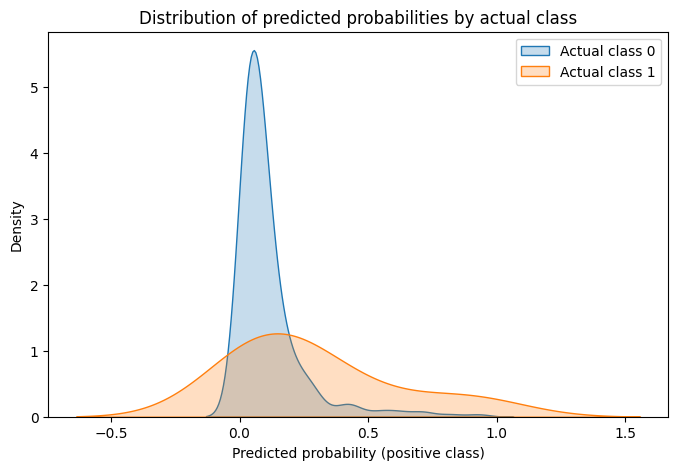

In [20]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

In [21]:
# -----------------------------
# Step 5: Calibrate probabilities of the best model
# -----------------------------
from sklearn.calibration import CalibratedClassifierCV
best_model = search.best_estimator_

calibrated_clf = CalibratedClassifierCV(
    estimator=best_model,
    method='isotonic',  # or 'isotonic'
    cv=4                # internal CV for calibration
)

calibrated_clf.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,method,'isotonic'
,cv,4
,n_jobs,None
,ensemble,'auto'
,sampling_strategy,0.2931790751820213
,random_state,42
,n_neighbors,5
,n_estimators,260
,criterion,'gini'
,max_depth,9


In [22]:
y_pred=calibrated_clf.predict(X_test)
y_proba=calibrated_clf.predict_proba(X_test)[:,1]

In [23]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9804    0.9960    0.9881       251
           1     0.5000    0.1667    0.2500         6

    accuracy                         0.9767       257
   macro avg     0.7402    0.5813    0.6191       257
weighted avg     0.9692    0.9767    0.9709       257



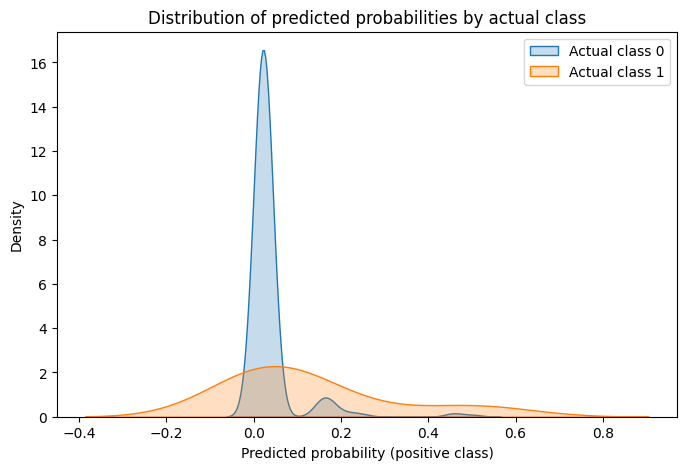

In [24]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

In [25]:
from optuna.integration import OptunaSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
import optuna

# -----------------------------
# Step 1: Define classifiers
# -----------------------------
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
xgb = XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1)

voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft'
)

# -----------------------------
# Step 2: Build pipeline
# -----------------------------
pipeline = Pipeline([
    ('sampler', ADASYN(random_state=42)),
    ('clf', voting_clf)
])

# -----------------------------
# Step 3: Define Optuna parameter search space
# -----------------------------
param_distributions = {
    'sampler__sampling_strategy': optuna.distributions.FloatDistribution(0.25, 0.75),
    'clf__rf__n_estimators': optuna.distributions.IntDistribution(100, 500),
    'clf__rf__max_depth': optuna.distributions.IntDistribution(5, 50),
    'clf__rf__min_samples_split': optuna.distributions.IntDistribution(2, 25),
    'clf__rf__max_leaf_nodes': optuna.distributions.IntDistribution(10, 100),
    'clf__rf__class_weight': optuna.distributions.CategoricalDistribution([None, 'balanced']),
    'clf__xgb__n_estimators': optuna.distributions.IntDistribution(100, 500),
    'clf__xgb__max_depth': optuna.distributions.IntDistribution(3, 20),
    'clf__xgb__learning_rate': optuna.distributions.FloatDistribution(0.01, 0.3, log=True),
    'clf__xgb__scale_pos_weight': optuna.distributions.FloatDistribution(1, 10),
}

# -----------------------------
# Step 4: Run OptunaSearchCV
# -----------------------------
search = OptunaSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_trials=100,
    cv=4,
    scoring='average_precision',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search.fit(X_train, y_train)
print("Best params:", search.best_params_)
print("Best score:", search.best_score_)

C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_35828\2181162572.py:49: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  search = OptunaSearchCV(
[I 2025-11-04 13:44:55,710] A new study created in memory with name: no-name-c8d3cb2b-0f83-4d1e-bbd8-7571b516b4f1
[I 2025-11-04 13:45:27,701] Trial 4 finished with value: 0.07591001406507387 and parameters: {'sampler__sampling_strategy': 0.4120981537929751, 'clf__rf__n_estimators': 259, 'clf__rf__max_depth': 48, 'clf__rf__min_samples_split': 24, 'clf__rf__max_leaf_nodes': 89, 'clf__rf__class_weight': 'balanced', 'clf__xgb__n_estimators': 139, 'clf__xgb__max_depth': 10, 'clf__xgb__learning_rate': 0.27437419648445804, 'clf__xgb__scale_pos_weight': 9.591394004007636}. Best is trial 4 with value: 0.07591001406507387.
[I 2025-11-04 13:45:27,708] Trial 0 finished with value: 0.10258757948279826 and parameters: {'sampler__sampling_strategy': 0.5265986184873506, 'clf__rf__n_esti

Best params: {'sampler__sampling_strategy': 0.28132993279698826, 'clf__rf__n_estimators': 101, 'clf__rf__max_depth': 45, 'clf__rf__min_samples_split': 9, 'clf__rf__max_leaf_nodes': 73, 'clf__rf__class_weight': None, 'clf__xgb__n_estimators': 193, 'clf__xgb__max_depth': 17, 'clf__xgb__learning_rate': 0.019421568844120073, 'clf__xgb__scale_pos_weight': 1.7889597372995245}
Best score: 0.1375507194938165


In [26]:
y_pred=search.predict(X_test)
y_proba=search.predict_proba(X_test)[:,1]

In [27]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9799    0.9721    0.9760       251
           1     0.1250    0.1667    0.1429         6

    accuracy                         0.9533       257
   macro avg     0.5525    0.5694    0.5594       257
weighted avg     0.9600    0.9533    0.9565       257



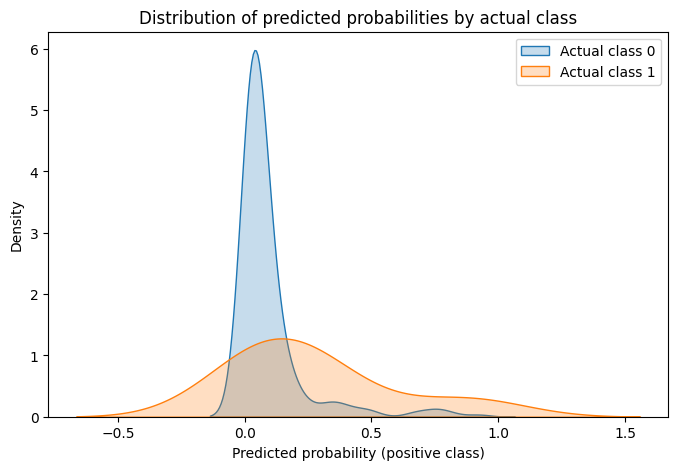

In [28]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()

In [29]:
# -----------------------------
# Step 5: Calibrate probabilities of the best model
# -----------------------------
best_model = search.best_estimator_

calibrated_clf = CalibratedClassifierCV(
    estimator=best_model,
    method='isotonic',  # or 'isotonic'
    cv=4                # internal CV for calibration
)

calibrated_clf.fit(X_train, y_train)

,estimator,Pipeline(step...ing='soft'))])
,method,'isotonic'
,cv,4
,n_jobs,None
,ensemble,'auto'
,sampling_strategy,0.28132993279698826
,random_state,42
,n_neighbors,5
,estimators,"[('rf', ...), ('xgb', ...)]"
,voting,'soft'
,weights,None


In [30]:
y_pred=calibrated_clf.predict(X_test)
y_proba=calibrated_clf.predict_proba(X_test)[:,1]

In [31]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9767    1.0000    0.9882       251
           1     0.0000    0.0000    0.0000         6

    accuracy                         0.9767       257
   macro avg     0.4883    0.5000    0.4941       257
weighted avg     0.9539    0.9767    0.9651       257



C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


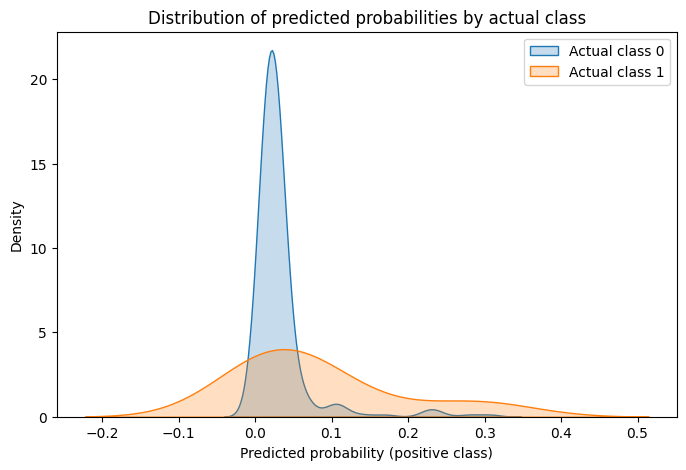

In [32]:
df_plot = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})

# Plot distributions
plt.figure(figsize=(8,5))
sns.kdeplot(data=df_plot[df_plot['y_test'] == 0]['y_proba'], label='Actual class 0', fill=True)
sns.kdeplot(data=df_plot[df_plot['y_test'] == 1]['y_proba'], label='Actual class 1', fill=True)
plt.title("Distribution of predicted probabilities by actual class")
plt.xlabel("Predicted probability (positive class)")
plt.ylabel("Density")
plt.legend()